# Library Imports and Hardware Configuration

In [ ]:
import os
import time
import copy
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
import pandas as pd
import seaborn as sns
import cv2
import random
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
cpu_count = os.cpu_count()
cpu_count

2

# Mount with the Google Drive

In [ ]:
drive.mount('/content/drive')
zip_path = "/content/drive/My Drive/GarbageDataSets/GarbageData.zip"

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")

In [ ]:
base_dir = "/content/data/garbage_classification/"


# Total classes

In [ ]:
classes = [
    "white-glass",
    "trash",
    "shoes",
    "plastic",
    "paper",
    "metal",
    "green-glass",
    "clothes",
    "cardboard",
    "brown-glass",
    "biological",
    "battery"
]

In [ ]:
data = pd.DataFrame(columns=['path', 'filename', 'target'])

In [ ]:
IMG_SIZE = 224

In [ ]:
# Loop through each class
for category in classes:
    class_path = os.path.join(base_dir, category)

    # Get all image files in the class directory
    photos = [f for f in os.listdir(class_path)]

    # Create temp DataFrame for the current class
    temp = pd.DataFrame({
        'path': [os.path.join(class_path, photo) for photo in photos],
        'filename': [f"{category}/{photo}" for photo in photos],
        'target': category
    })

    # Append to main DataFrame
    data = pd.concat([data, temp], ignore_index=True)

# Verify
print(f"Total samples: {len(data)}")
print(data.head())


Total samples: 15515
                                                path  \
0  /content/data/garbage_classification/white-gla...   
1  /content/data/garbage_classification/white-gla...   
2  /content/data/garbage_classification/white-gla...   
3  /content/data/garbage_classification/white-gla...   
4  /content/data/garbage_classification/white-gla...   

                         filename       target  
0  white-glass/white-glass605.jpg  white-glass  
1  white-glass/white-glass440.jpg  white-glass  
2  white-glass/white-glass459.jpg  white-glass  
3   white-glass/white-glass50.jpg  white-glass  
4  white-glass/white-glass331.jpg  white-glass  


In [ ]:
data

path  \
0      /content/data/garbage_classification/white-gla...   
1      /content/data/garbage_classification/white-gla...   
2      /content/data/garbage_classification/white-gla...   
3      /content/data/garbage_classification/white-gla...   
4      /content/data/garbage_classification/white-gla...   
...                                                  ...   
15510  /content/data/garbage_classification/battery/b...   
15511  /content/data/garbage_classification/battery/b...   
15512  /content/data/garbage_classification/battery/b...   
15513  /content/data/garbage_classification/battery/b...   
15514  /content/data/garbage_classification/battery/b...   

                             filename       target  
0      white-glass/white-glass605.jpg  white-glass  
1      white-glass/white-glass440.jpg  white-glass  
2      white-glass/white-glass459.jpg  white-glass  
3       white-glass/white-glass50.jpg  white-glass  
4      white-glass/white-glass331.jpg  white-glass  
...                               ...          ...  
15510          battery/battery583.jpg      battery  
15511          battery/battery711.jpg      battery  
15512          battery/battery601.jpg      battery  
15513          battery/battery114.jpg      battery  
15514          battery/battery848.jpg      battery  

[15515 rows x 3 columns]

In [ ]:
data['target'].unique()

array(['white-glass', 'trash', 'shoes', 'plastic', 'paper', 'metal',
       'green-glass', 'clothes', 'cardboard', 'brown-glass', 'biological',
       'battery'], dtype=object)

# Looping through random image of dataset


/content/data/garbage_classification/clothes/clothes1837.jpg


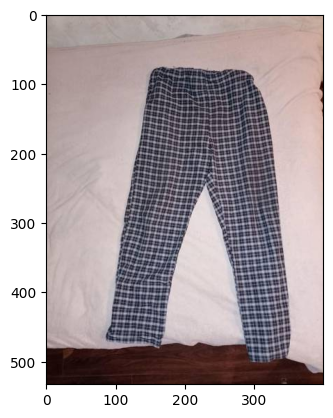

/content/data/garbage_classification/paper/paper291.jpg


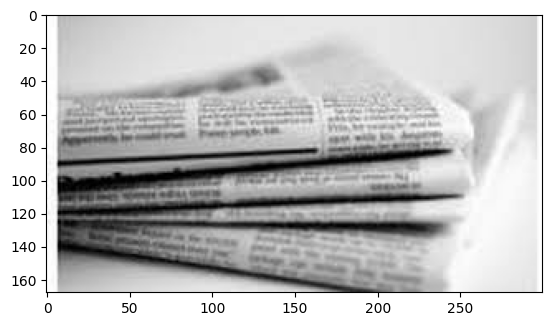

/content/data/garbage_classification/battery/battery620.jpg


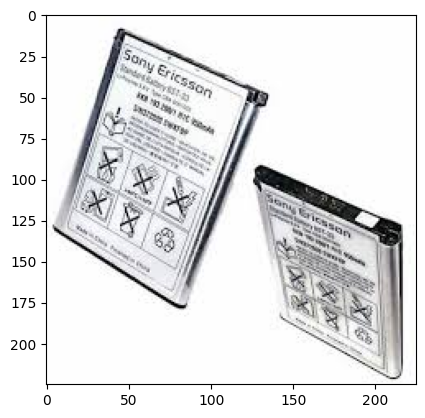

/content/data/garbage_classification/clothes/clothes2250.jpg


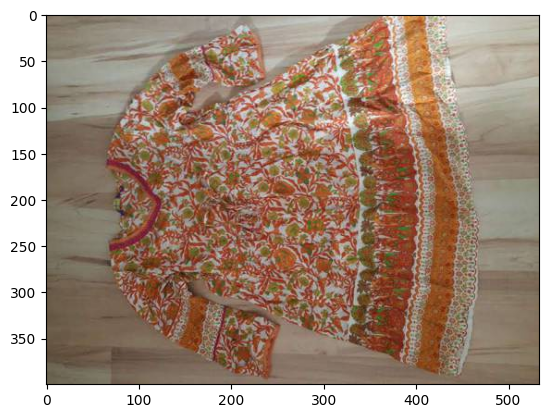

/content/data/garbage_classification/biological/biological321.jpg


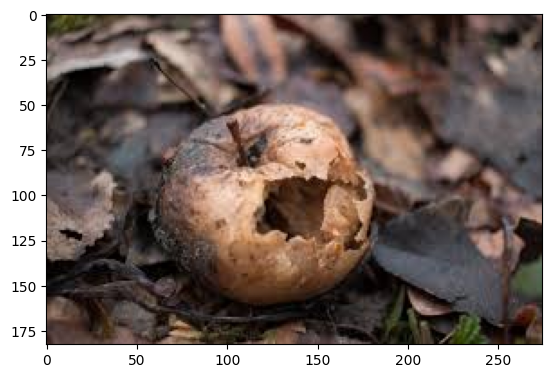

/content/data/garbage_classification/shoes/shoes1741.jpg


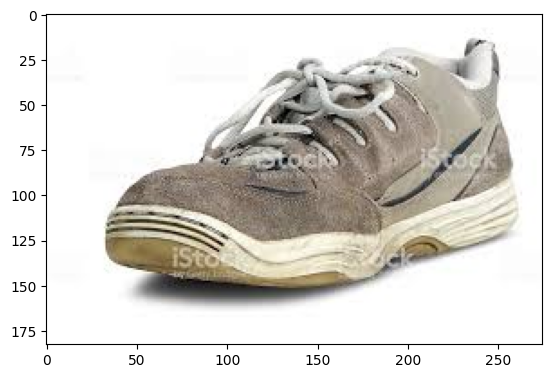

/content/data/garbage_classification/white-glass/white-glass624.jpg


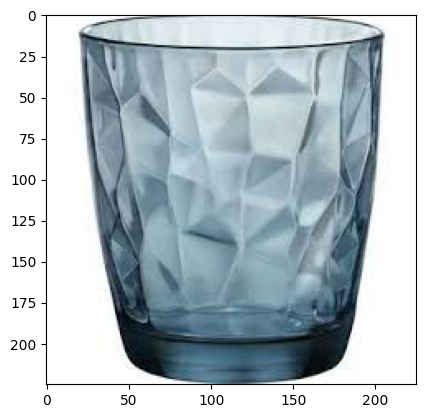

/content/data/garbage_classification/clothes/clothes3251.jpg


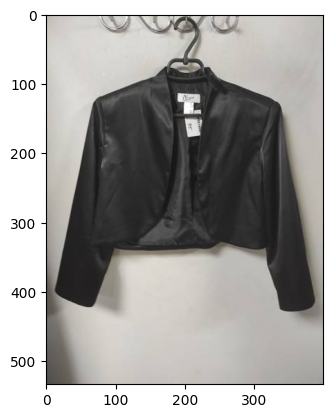

/content/data/garbage_classification/shoes/shoes1140.jpg


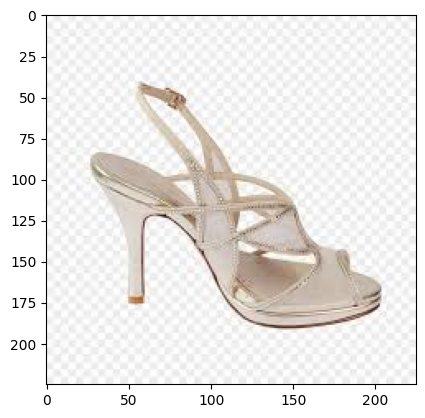

/content/data/garbage_classification/clothes/clothes418.jpg


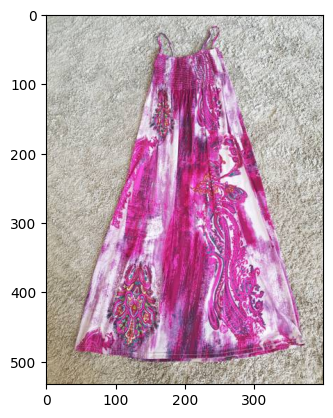

In [ ]:
for i in range (10):
    random_row = random.randint(0, len(data)-1)
    sample = data.iloc[random_row]
    image = mpimg.imread(sample['path'])
    plt.imshow(image)
    print(sample['path'])
    plt.show()

# Total count of each class

In [ ]:
total_counts = 0


for category in os.listdir(base_dir):
    count_class = 0
    # Add slash between path and category
    category_full_path = os.path.join(base_dir, category)

    # Skip if not a directory
    if not os.path.isdir(category_full_path):
        continue

    for photo in os.listdir(category_full_path):
        count_class += 1
        total_counts += 1
    print(f"{category} has {count_class} photos")

print(f"\nTotal photos: {total_counts}")

shoes has 1977 photos
white-glass has 775 photos
green-glass has 629 photos
battery has 945 photos
cardboard has 891 photos
biological has 985 photos
clothes has 5325 photos
paper has 1050 photos
brown-glass has 607 photos
plastic has 865 photos
trash has 697 photos
metal has 769 photos

Total photos: 15515


In [ ]:
data['target'].value_counts()

target
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64

In [ ]:
data

path  \
0      /content/data/garbage_classification/white-gla...   
1      /content/data/garbage_classification/white-gla...   
2      /content/data/garbage_classification/white-gla...   
3      /content/data/garbage_classification/white-gla...   
4      /content/data/garbage_classification/white-gla...   
...                                                  ...   
15510  /content/data/garbage_classification/battery/b...   
15511  /content/data/garbage_classification/battery/b...   
15512  /content/data/garbage_classification/battery/b...   
15513  /content/data/garbage_classification/battery/b...   
15514  /content/data/garbage_classification/battery/b...   

                             filename       target  
0      white-glass/white-glass605.jpg  white-glass  
1      white-glass/white-glass440.jpg  white-glass  
2      white-glass/white-glass459.jpg  white-glass  
3       white-glass/white-glass50.jpg  white-glass  
4      white-glass/white-glass331.jpg  white-glass  
...                               ...          ...  
15510          battery/battery583.jpg      battery  
15511          battery/battery711.jpg      battery  
15512          battery/battery601.jpg      battery  
15513          battery/battery114.jpg      battery  
15514          battery/battery848.jpg      battery  

[15515 rows x 3 columns]

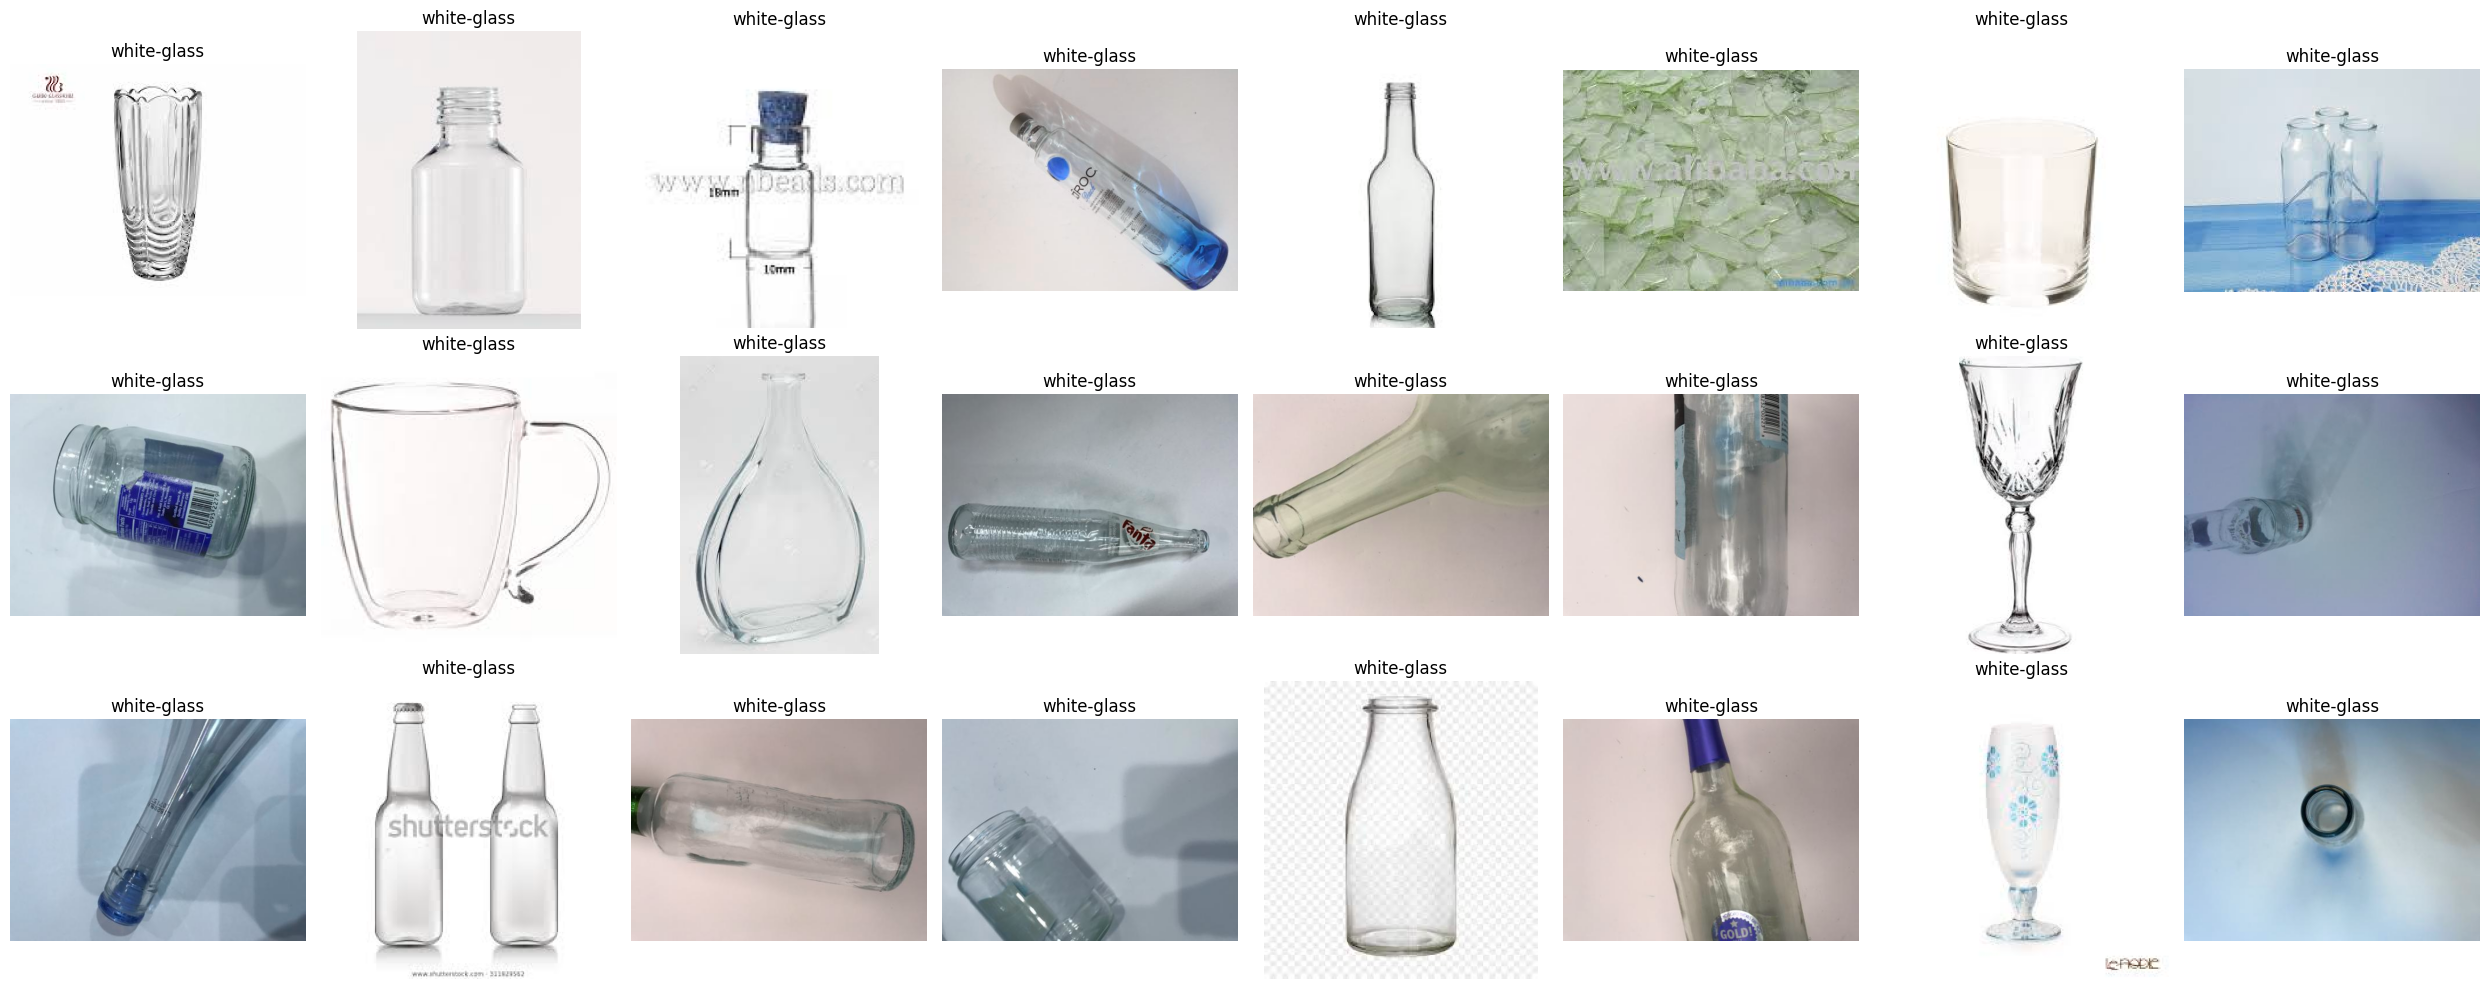

In [ ]:
imgPaths = data['path']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

<ipython-input-19-3a4b8330395b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=data, palette='Blues')


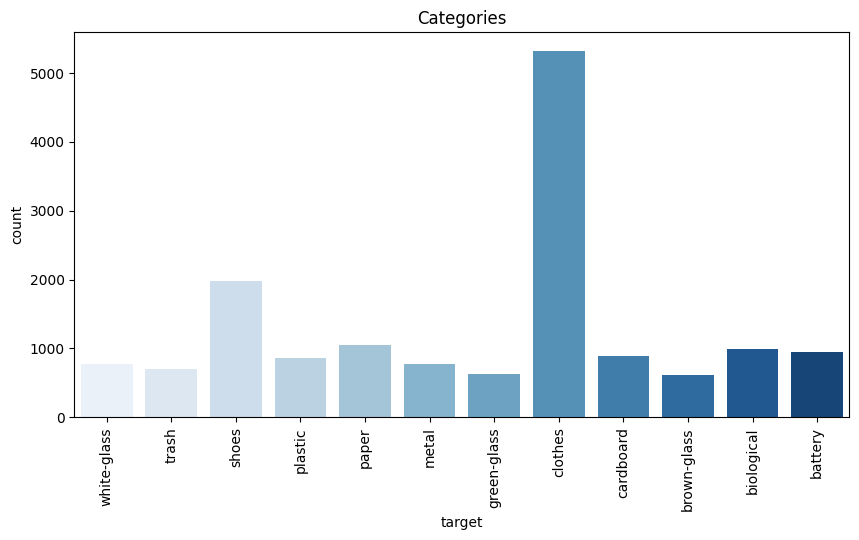

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="target", data=data, palette='Blues')
plt.xticks(rotation=90)
plt.title('Categories')
plt.show()

# Function to split data into train and validation

In [ ]:
def create_dataset_splits():
    # Dictionary to store image paths for each class
    class_images = {cls: [] for cls in classes}

    # Collect all image paths by class
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        if os.path.exists(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    class_images[class_name].append(img_path)
        else:
            print(f"Warning: Directory not found for class {class_name}")

    # Split into train and validation sets (80/20 split)
    train_images = []
    val_images = []
    train_labels = []
    val_labels = []

    for class_idx, class_name in enumerate(classes):
        images = class_images[class_name]
        print(f"Class {class_name}: {len(images)} images")

        if len(images) > 0:
            # Split 80% train, 20% validation
            train_imgs, val_imgs = train_test_split(
                images, test_size=0.2, random_state=42
            )

            train_images.extend(train_imgs)
            val_images.extend(val_imgs)
            train_labels.extend([class_idx] * len(train_imgs))
            val_labels.extend([class_idx] * len(val_imgs))

    return {
        'train': (train_images, train_labels),
        'val': (val_images, val_labels)
    }



In [ ]:
# Create the dataset splits
dataset_splits = create_dataset_splits()

Class white-glass: 775 images
Class trash: 697 images
Class shoes: 1977 images
Class plastic: 865 images
Class paper: 1050 images
Class metal: 769 images
Class green-glass: 629 images
Class clothes: 5325 images
Class cardboard: 891 images
Class brown-glass: 607 images
Class biological: 985 images
Class battery: 945 images


In [ ]:
class GarbageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data Transformation

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets

In [ ]:
# Create datasets
image_datasets = {
    x: GarbageDataset(
        dataset_splits[x][0],
        dataset_splits[x][1],
        data_transforms[x]
    ) for x in ['train', 'val']
}

# Create dataloaders

In [ ]:
# Create dataloaders
dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=32,
        shuffle=True,
        num_workers=2
    ) for x in ['train', 'val']
}

# Data size of training and validation data

In [ ]:
# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
num_classes = len(classes)

print(f"Total images: {dataset_sizes['train'] + dataset_sizes['val']}")
print(f"Training images: {dataset_sizes['train']}")
print(f"Validation images: {dataset_sizes['val']}")
print(f"Number of classes: {num_classes}")

Total images: 15515
Training images: 12409
Validation images: 3106
Number of classes: 12


# Load the model

In [ ]:
model_ft = models.resnet50(weights='IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)  # num_classes = 12

In [ ]:
model_ft = model_ft.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Learning rate scheduler to reduce LR by factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Function to train the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # For tracking metrics
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history only if in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the scheduler if in training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if best accuracy achieved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save checkpoint to Google Drive (always use the same filename to keep only the best model)
                checkpoint_path = '/content/drive/My Drive/GarbageDataSets/garbage_resnet50_best.pth'
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_acc': best_acc,
                    'class_names': classes
                }, checkpoint_path)
                print(f"Best model updated at epoch {epoch} with accuracy {best_acc:.4f}")
                print(f"Checkpoint saved to Drive: {checkpoint_path}")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/training_curves.png')
    # Also save to Drive
    plt.savefig('/content/drive/My Drive/GarbageDataSets/garbage_training_curves.png')
    plt.show()

    return model

# Train and evaluate the model

Epoch 0/24
----------
train Loss: 0.9384 Acc: 0.7120
val Loss: 0.4874 Acc: 0.8609
Best model updated at epoch 0 with accuracy 0.8609
Checkpoint saved to Drive: /content/drive/My Drive/GarbageDataSets/garbage_resnet50_best.pth

Epoch 1/24
----------
train Loss: 0.6394 Acc: 0.7941
val Loss: 0.4370 Acc: 0.8654
Best model updated at epoch 1 with accuracy 0.8654
Checkpoint saved to Drive: /content/drive/My Drive/GarbageDataSets/garbage_resnet50_best.pth

Epoch 2/24
----------
train Loss: 0.6072 Acc: 0.8041
val Loss: 0.4346 Acc: 0.8722
Best model updated at epoch 2 with accuracy 0.8722
Checkpoint saved to Drive: /content/drive/My Drive/GarbageDataSets/garbage_resnet50_best.pth

Epoch 3/24
----------
train Loss: 0.5806 Acc: 0.8142
val Loss: 0.5161 Acc: 0.8558

Epoch 4/24
----------
train Loss: 0.5434 Acc: 0.8273
val Loss: 0.4079 Acc: 0.8793
Best model updated at epoch 4 with accuracy 0.8793
Checkpoint saved to Drive: /content/drive/My Drive/GarbageDataSets/garbage_resnet50_best.pth

Epoch 5/2

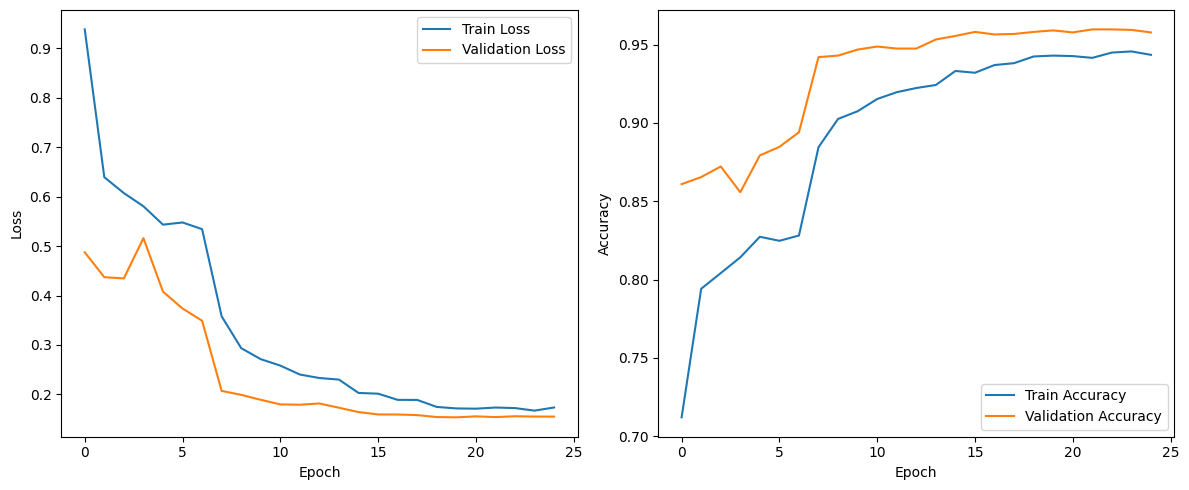

Final model saved to Drive: /content/drive/My Drive/GarbageDataSets/garbage_resnet50_final_model.pth


In [ ]:

num_epochs = 25
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Save the final model to Google Drive
final_model_path = '/content/drive/My Drive/GarbageDataSets/garbage_resnet50_final_model.pth'
torch.save({
    'model_state_dict': model_ft.state_dict(),
    'class_names': classes,
    'num_classes': num_classes
}, final_model_path)
print(f"Final model saved to Drive: {final_model_path}")

# Save the final model to Google Drive

In [ ]:
final_model_path = '/content/drive/My Drive/GarbageDataSets/garbage_resnet50_final_model.pth'
torch.save({
    'model_state_dict': model_ft.state_dict(),
    'class_names': classes,
    'num_classes': num_classes
}, final_model_path)
print(f"Final model saved to Drive: {final_model_path}")

Final model saved to Drive: /content/drive/My Drive/GarbageDataSets/garbage_resnet50_final_model.pth


# Visulaize model prediction

In [ ]:
# Function to visualize model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3 + 1, 3, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {classes[preds[j]]} | Actual: {classes[labels[j]]}')

                # Convert image for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.savefig('/content/sample_predictions.png')
                    plt.savefig('/content/drive/My Drive/GarbageDataSets/garbage_sample_predictions.png')
                    return
        model.train(mode=was_training)


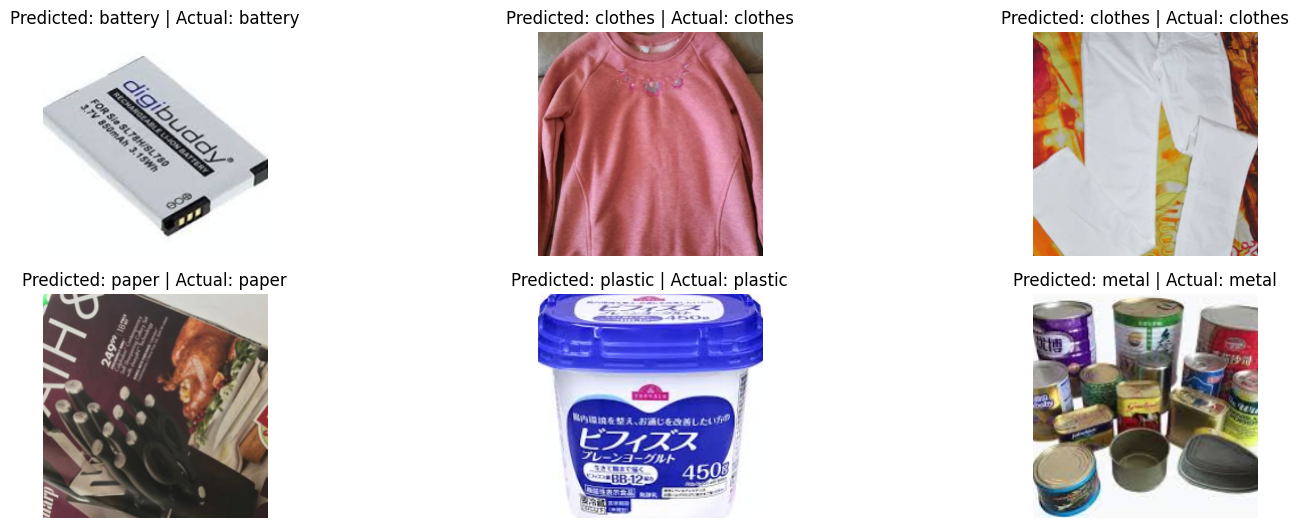

In [ ]:
visualize_model(model_ft)

# Evaluate the Model

In [ ]:
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate and plot confusion matrix

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('/content/confusion_matrix.png')
    plt.savefig('/content/drive/My Drive/GarbageDataSets/garbage_confusion_matrix.png')

    # Print classification report with per-class metrics
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:")
    print(report)

    # Save report to a text file
    with open('/content/drive/My Drive/GarbageDataSets/garbage_classification_report.txt', 'w') as f:
        f.write(report)

    # Return the accuracy for each class
    class_accuracies = {}
    for i, class_name in enumerate(classes):
        # Calculate class accuracy from confusion matrix
        class_correct = cm[i, i]
        class_total = np.sum(cm[i, :])
        class_accuracy = class_correct / class_total
        class_accuracies[class_name] = class_accuracy
        print(f"Accuracy for class {class_name}: {class_accuracy:.4f}")

    return class_accuracies

Classification Report:
              precision    recall  f1-score   support

 white-glass       0.97      0.91      0.94       155
       trash       0.96      0.97      0.97       140
       shoes       0.95      0.96      0.95       396
     plastic       0.91      0.90      0.90       173
       paper       0.97      0.96      0.96       210
       metal       0.85      0.92      0.88       154
 green-glass       0.96      0.97      0.96       126
     clothes       0.99      0.99      0.99      1065
   cardboard       0.97      0.93      0.95       179
 brown-glass       0.95      0.93      0.94       122
  biological       0.98      0.94      0.96       197
     battery       0.94      0.95      0.94       189

    accuracy                           0.96      3106
   macro avg       0.95      0.94      0.95      3106
weighted avg       0.96      0.96      0.96      3106

Accuracy for class white-glass: 0.9097
Accuracy for class trash: 0.9714
Accuracy for class shoes: 0.9646
Accur

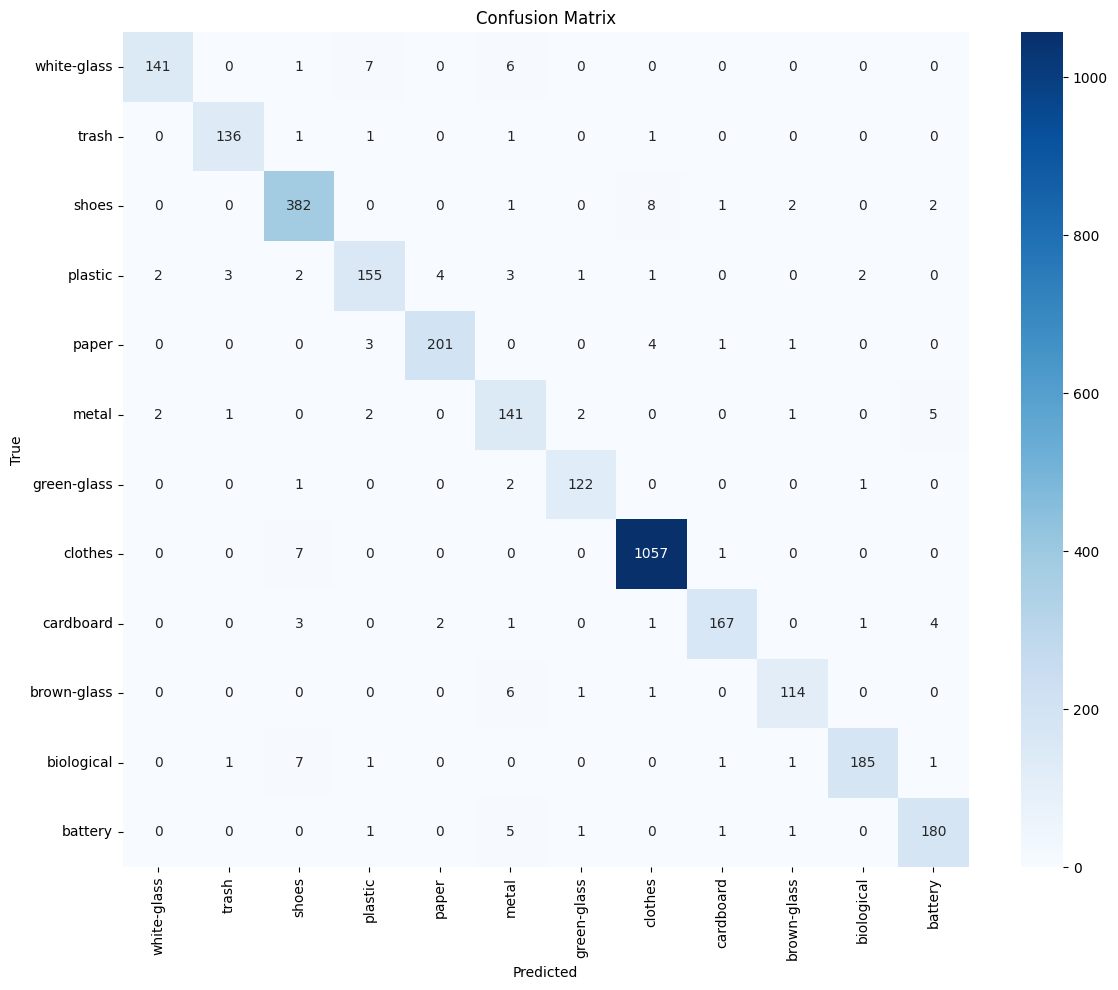

In [ ]:
class_accuracies = evaluate_model(model_ft)

# Visualize Each Class Accuracy

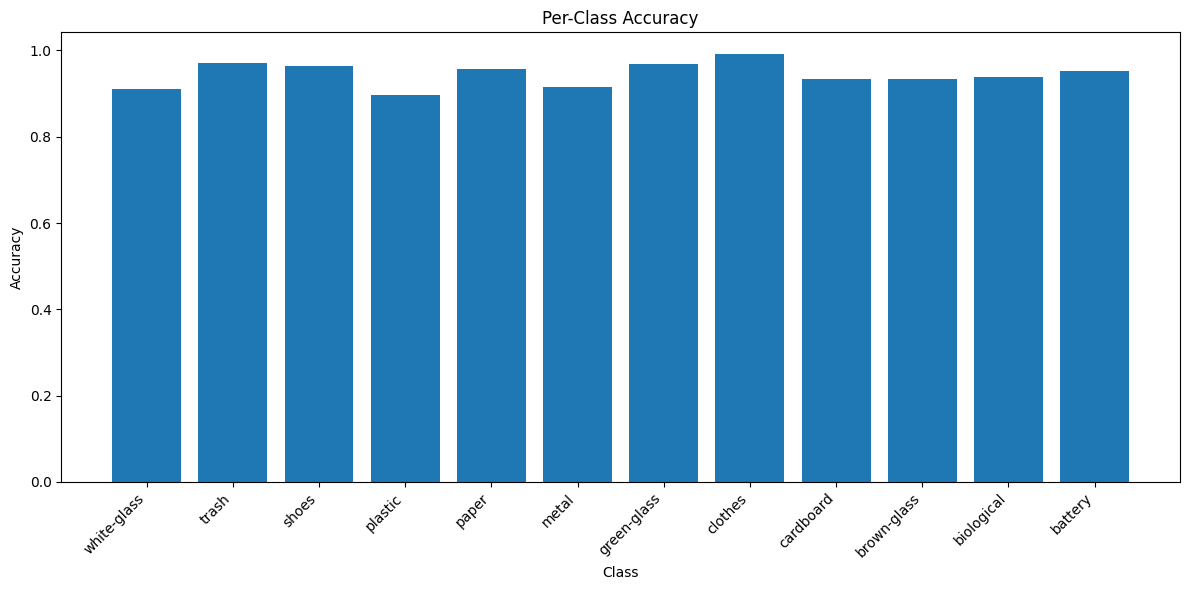

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(class_accuracies.keys(), class_accuracies.values())
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/per_class_accuracy.png')
plt.savefig('/content/drive/My Drive/GarbageDataSets/garbage_per_class_accuracy.png')
plt.show()

# Prediction In New Images

In [ ]:
def predict_image(model, image_path):
    model.eval()
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    transform = data_transforms['val']
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)

    predicted_class = classes[preds[0]]

    # Get confidence scores
    probs = torch.nn.functional.softmax(outputs, dim=1)[0]
    confidence = probs[preds[0]].item() * 100

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class}\\nConfidence: {confidence:.2f}%')
    plt.show()

    # Return top 3 predictions with confidence
    top_probs, top_classes = torch.topk(probs, 3)
    results = [(classes[i], p.item() * 100) for i, p in zip(top_classes, top_probs)]
    print("Top 3 predictions:")
    for cls, conf in results:
        print(f"{cls}: {conf:.2f}%")

    return predicted_class, confidence

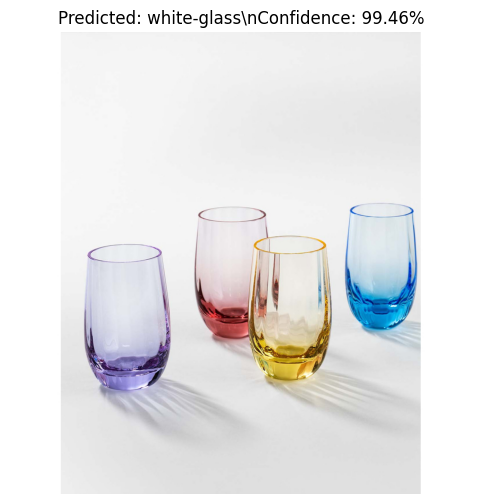

Top 3 predictions:
white-glass: 99.46%
green-glass: 0.29%
plastic: 0.11%


In [ ]:
predicted_class, confidence = predict_image(
    model=model_ft,
    image_path="/content/drive/My Drive/hello.jpg"
)